In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 15

# manifold.TSNE
from sklearn import manifold  #, datasets
from time import time

## Data and labels 
In this example we know the labels, hence we can test the performances of t-SNE and DBSCAN

In [2]:
fname,fnamey="x_3d.dat","y_3d.dat"
data=np.loadtxt("DATA/"+fname, delimiter='\t')
y=np.loadtxt("DATA/"+fnamey,dtype=int)
N=len(data)
D=len(data[0])
print("N=",N,"  D=",D)
x=data

N= 600   D= 3


## Find the typical minimum distance between points
This yields a typical scale, to be used as a reference for "eps"

In [3]:
def dist(x,i,j):
    return np.linalg.norm(x[i]-x[j])

print(dist(x,13,1))
mdist = np.zeros(N)
for i in range(N):
    dm = 1e100
    for j in range(N):
        if i!=j:
            dij = dist(x,i,j);
            if dij<dm:
                dm = dij
    mdist[i] = dm
mean_min_dist = mdist.mean()
print("mean minimum distance between points: ",mean_min_dist)

569.5269005085432
mean minimum distance between points:  23.321029500210262


## t-SNE visualization, for true labels

IndexError: index 5 is out of bounds for axis 0 with size 5

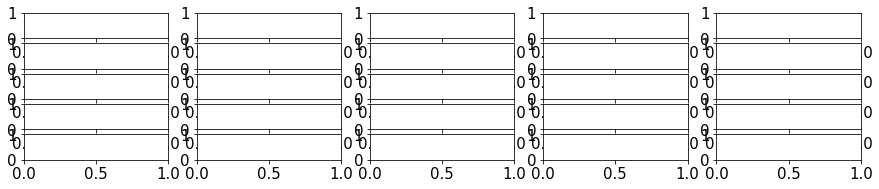

In [6]:
np.random.seed(0)
n_samples = N
n_components = 2 
perplexities = [5, 10, 20, 40, 80]
Np = len(perplexities)
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(5, Np , figsize=(3*Np, 2.7))

X_all = [None]
for i, perplexity in enumerate(perplexities):
    for j in range(6):
        ax = subplots[j,i]

        t0 = time()
        tsne = manifold.TSNE(n_components=n_components, init='random',
                             random_state=5, perplexity=perplexity)
        Y = tsne.fit_transform(data)
        t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)
    
plt.show()

## DBSCAN: find labels by applying clustering

In [ ]:
from sklearn.cluster import DBSCAN
#from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]
from collections import OrderedDict
ms = 6

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=ms)

# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(12345)
n_true_center=3
#X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
X2D = X_all[3] # best visualization above
X = data
y_true = y

nmi_array=np.zeros((25,30))
#eps_range = [0.01,0.1,0.5,1.0,10.]
if mean_min_dist<10:
    r=mean_min_dist
else:
    r = int(mean_min_dist)
eps_range = np.linspace(r,12*r,25)
min_sample_range = np.linspace(1,30,30)
fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(15,18))
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        plotting_ax(X2D,y_hat,ax[i,j])
        nmi=NMI(y_hat, y_true)
        ax[i,j].set_title('eps=%.2f, minPts=%i\nnmi=%.2f'%(eps,min_samples,nmi))
        nmi_array.append(nmi[:,j])
#plt.tight_layout(h_pad=0.5)
#plt.show()


In [ ]:
import seaborn as sns

data = np.random.random((12,20))

ax = sns.heatmap(data, linewidth=0.5)
plt.show()
#plt.colorbar(col, label='NMI')

In [ ]:
print(np.shape(nmi_array))

In [ ]:
ax = sns.heatmap(nmi_array, linewidth=0.5)
plt.show()